In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fftpack import fft, fftfreq
from scipy.signal import stft
from statsmodels.tsa.filters.hp_filter import hpfilter

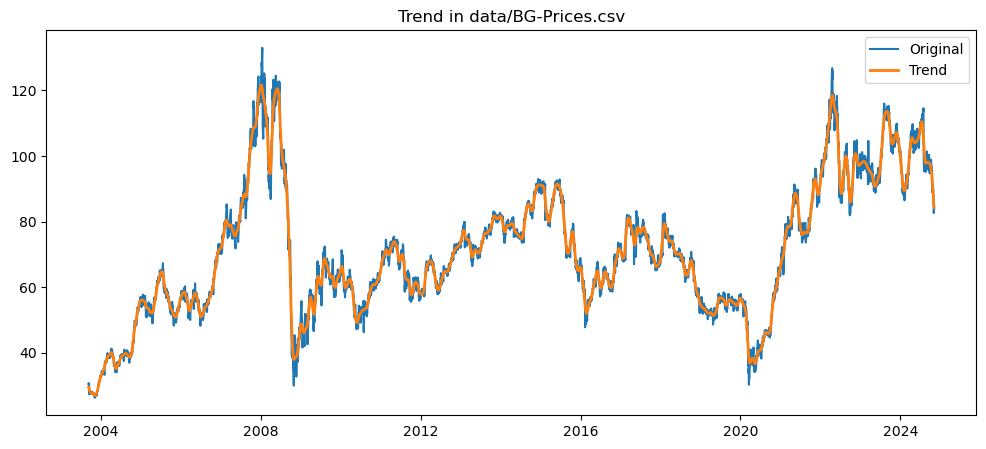

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 35.98 days, Amplitude: 0.37781
Period: 22.28 days, Amplitude: 0.27888
Period: 34.35 days, Amplitude: 0.27170
Period: 22.47 days, Amplitude: 0.25780
Period: 35.26 days, Amplitude: 0.24802


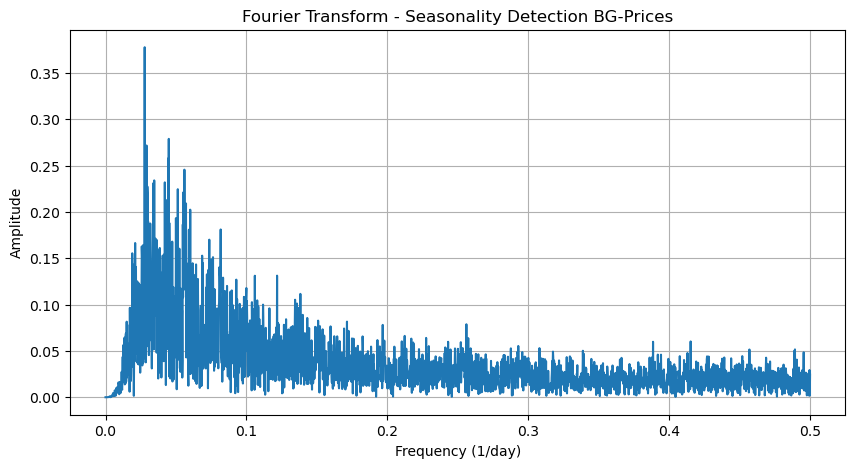

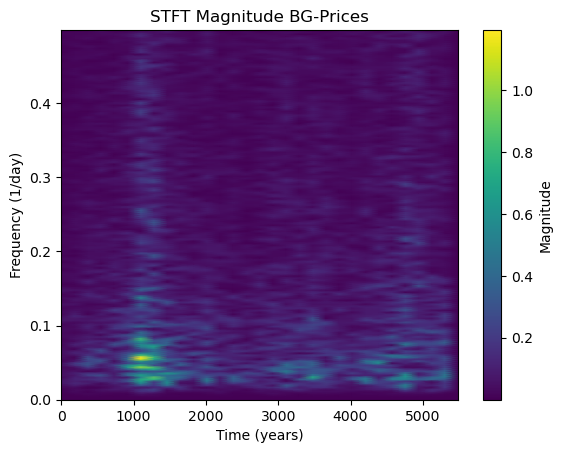

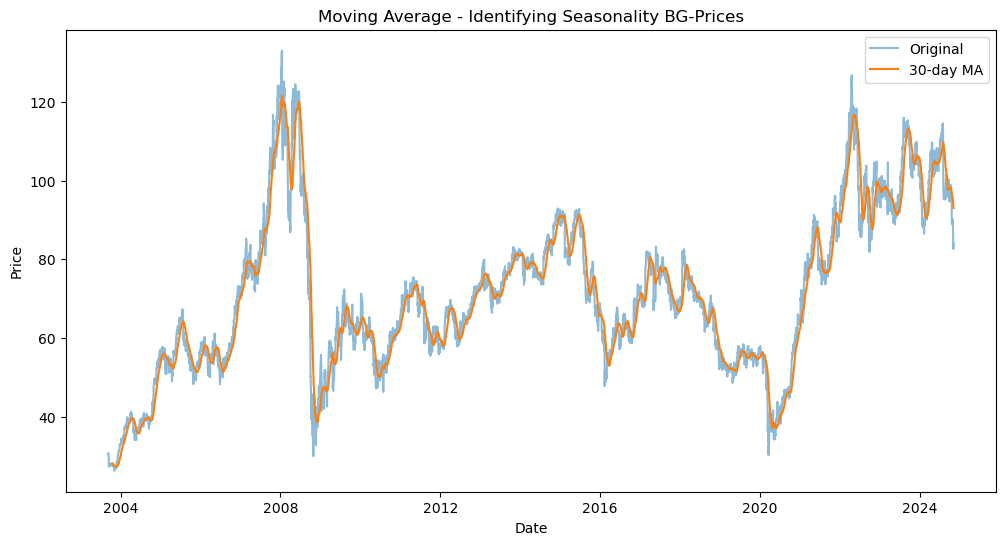

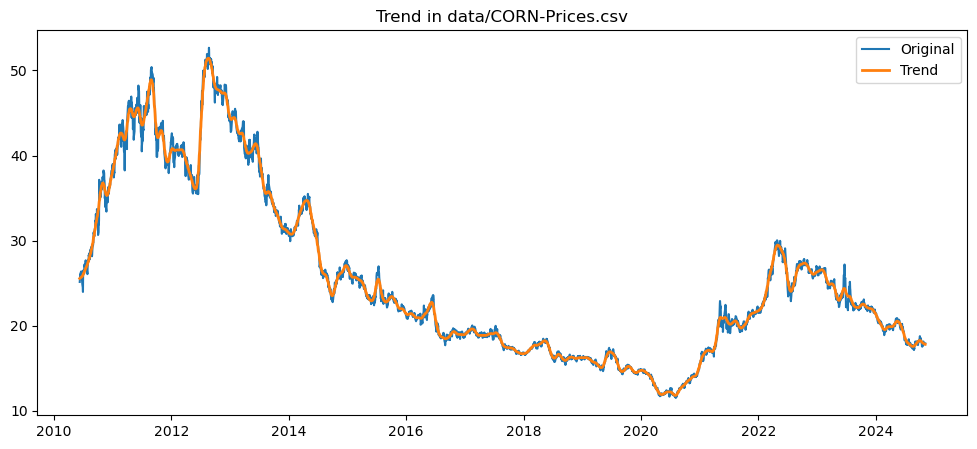

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 35.21 days, Amplitude: 0.10882
Period: 34.22 days, Amplitude: 0.09633
Period: 31.54 days, Amplitude: 0.09016
Period: 16.05 days, Amplitude: 0.07981
Period: 16.95 days, Amplitude: 0.07827


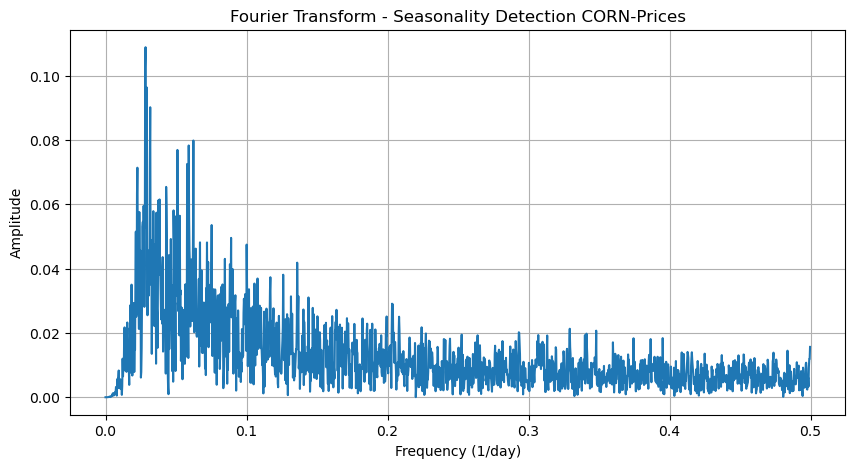

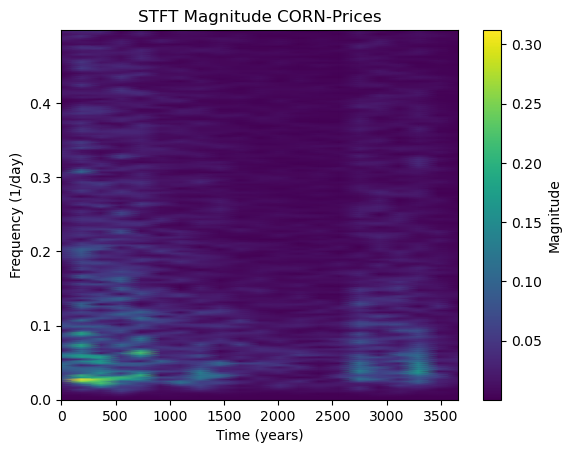

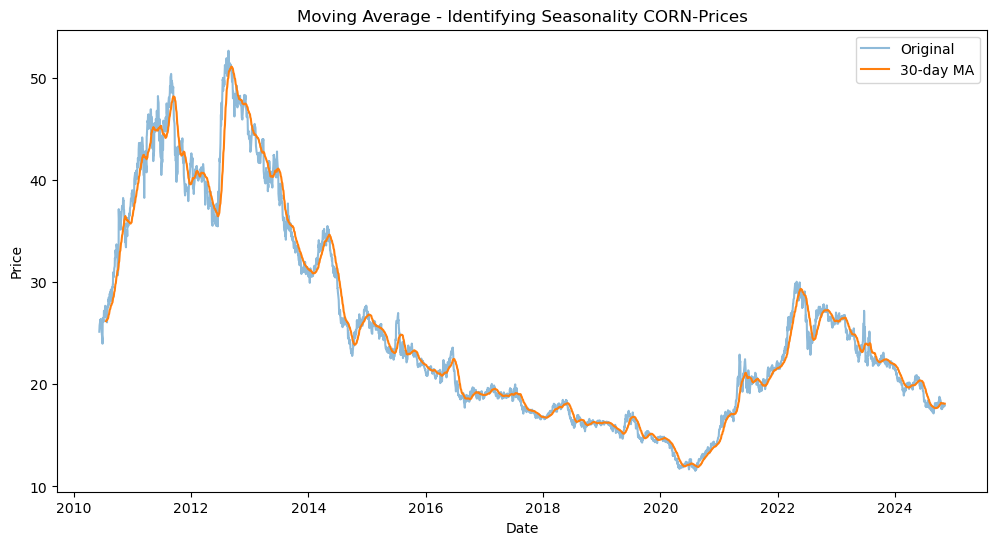

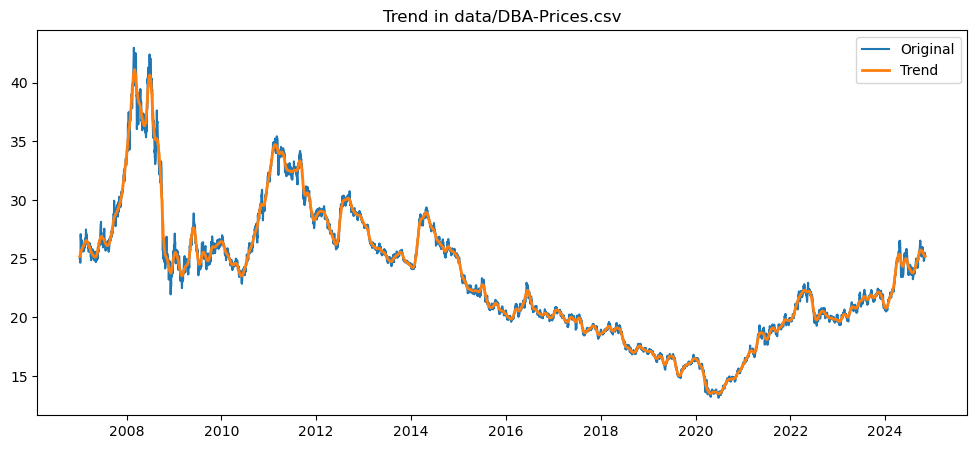

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 35.63 days, Amplitude: 0.05694
Period: 30.33 days, Amplitude: 0.05586
Period: 44.45 days, Amplitude: 0.05398
Period: 46.76 days, Amplitude: 0.05196
Period: 23.38 days, Amplitude: 0.04957


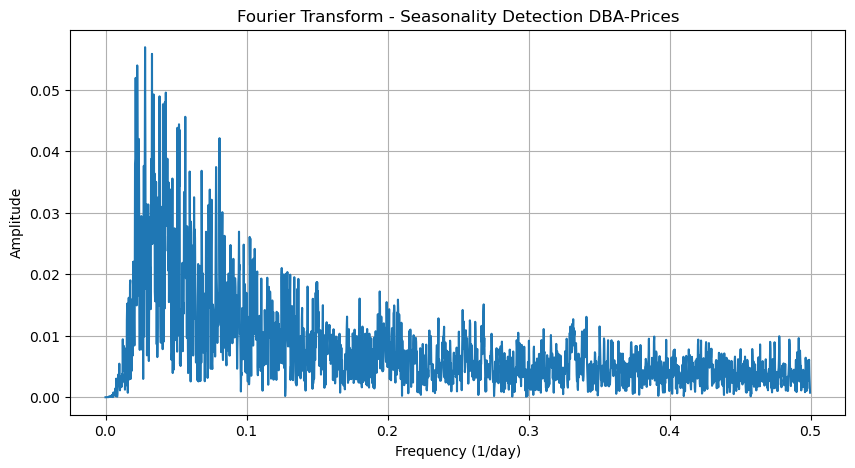

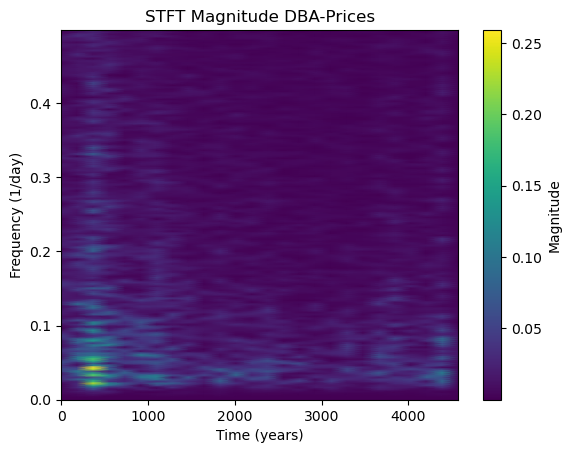

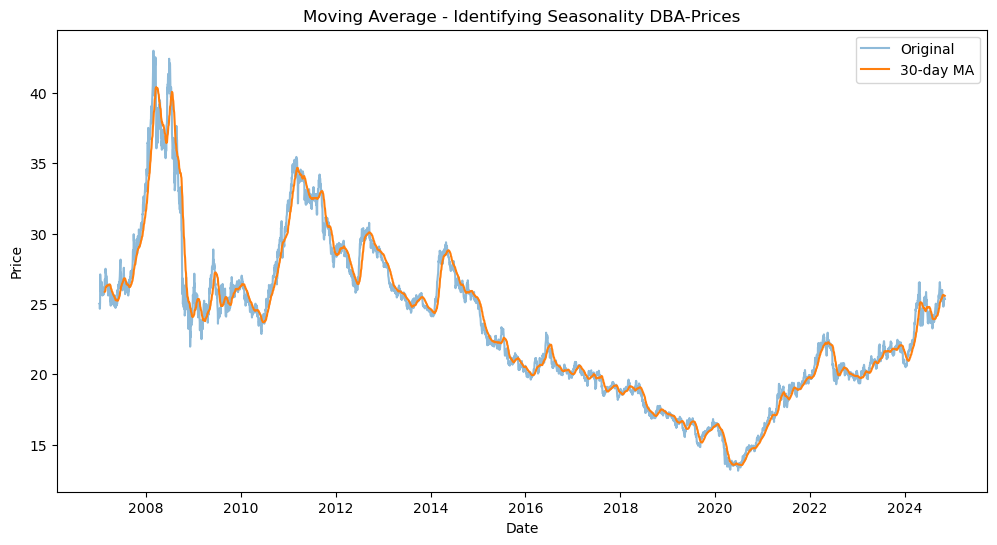

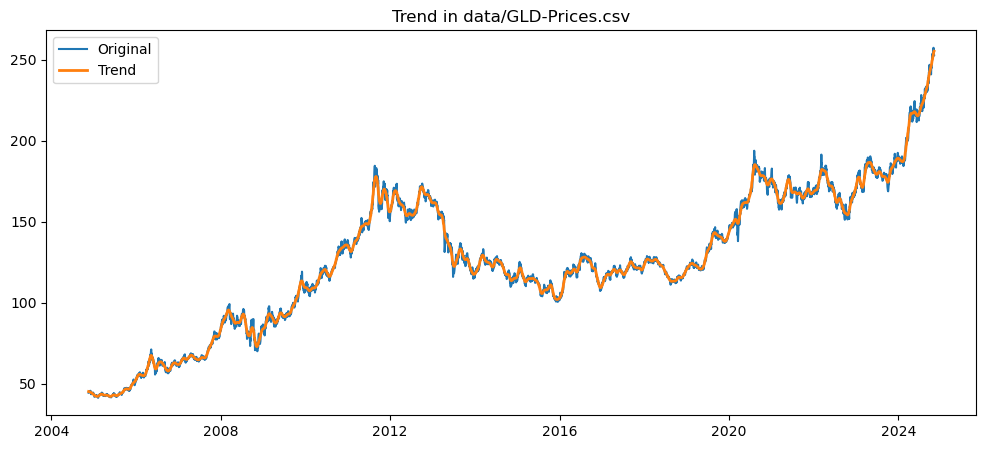

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 28.71 days, Amplitude: 0.33116
Period: 26.87 days, Amplitude: 0.31181
Period: 29.55 days, Amplitude: 0.30494
Period: 38.65 days, Amplitude: 0.28430
Period: 23.70 days, Amplitude: 0.27942


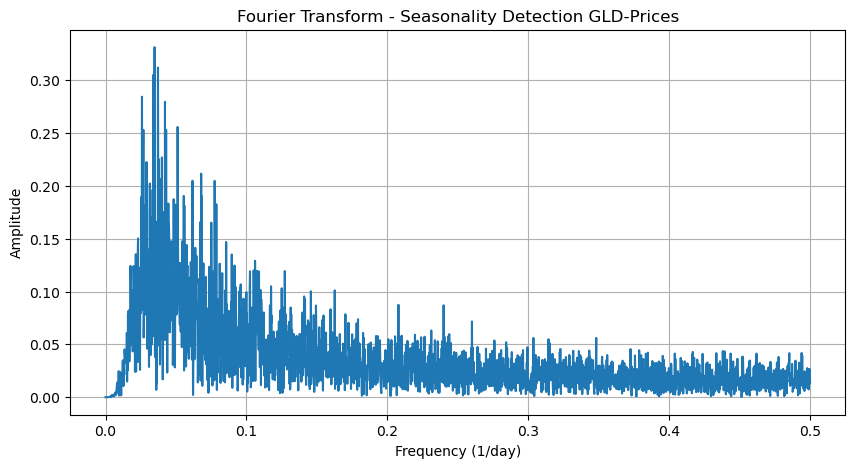

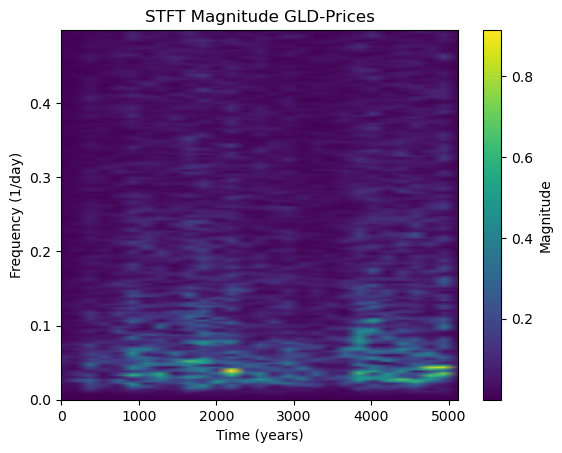

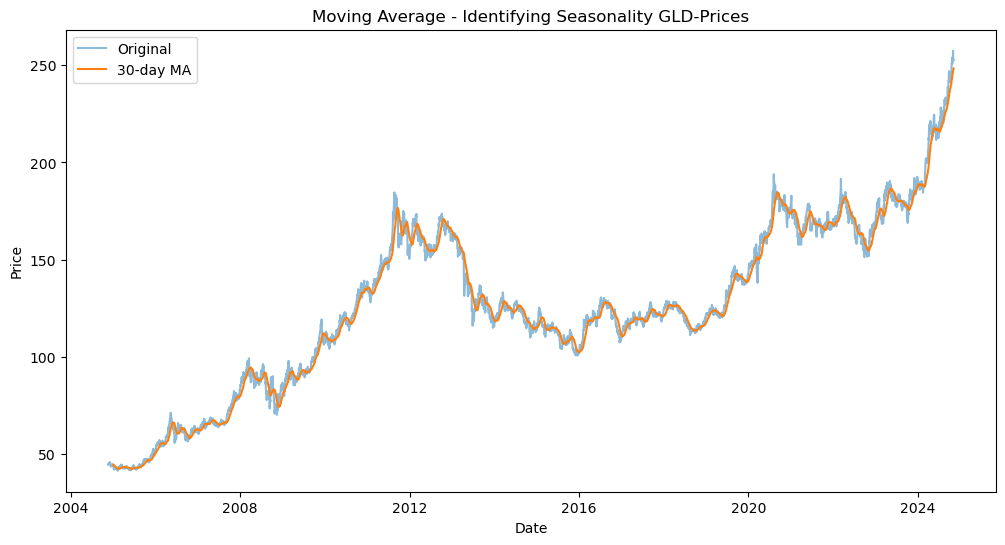

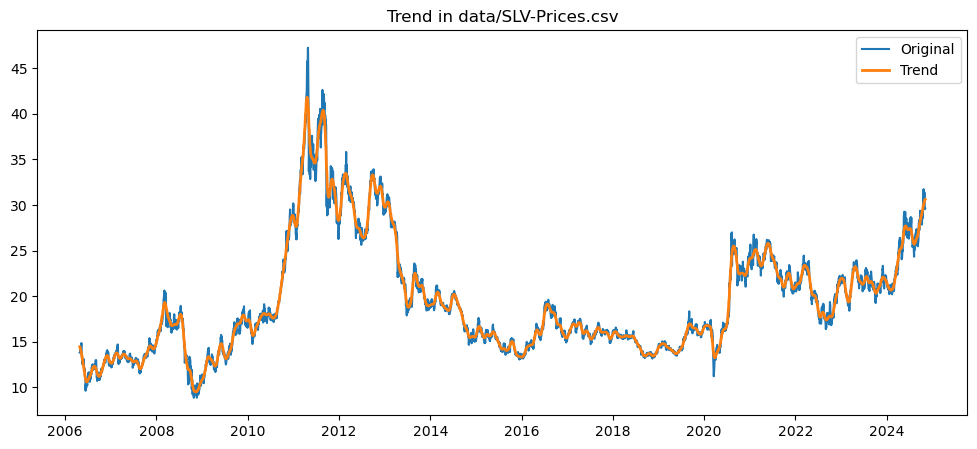

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 34.28 days, Amplitude: 0.12196
Period: 26.79 days, Amplitude: 0.10762
Period: 29.32 days, Amplitude: 0.09840
Period: 31.71 days, Amplitude: 0.08765
Period: 32.60 days, Amplitude: 0.08678


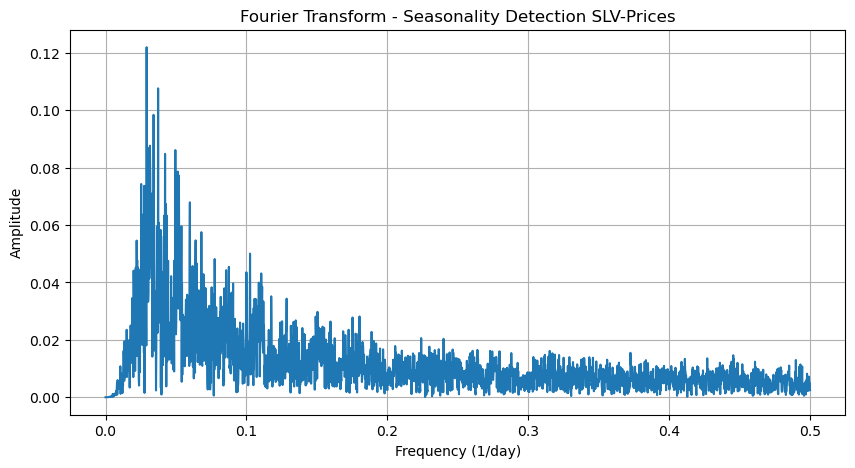

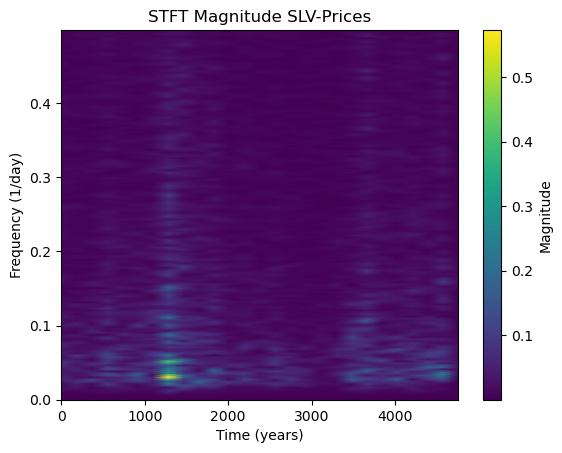

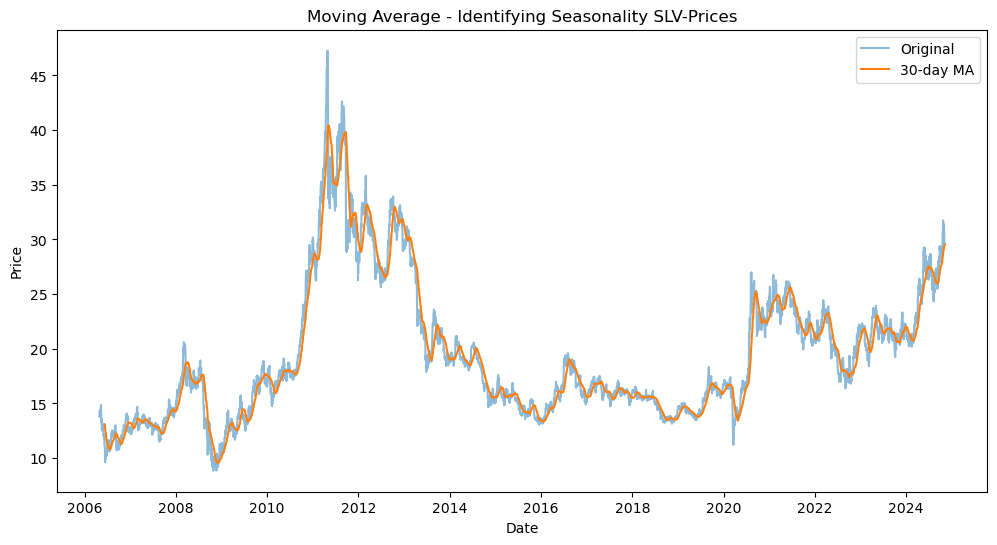

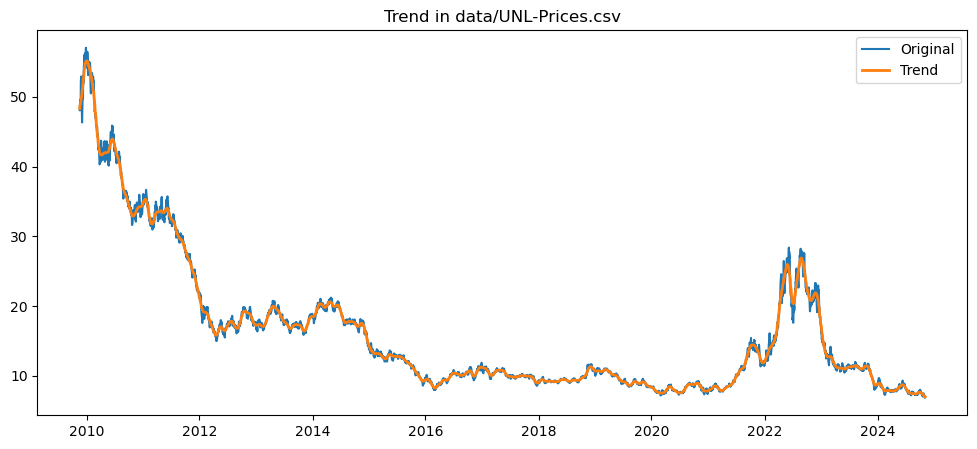

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 38.89 days, Amplitude: 0.08446
Period: 30.10 days, Amplitude: 0.08319
Period: 24.56 days, Amplitude: 0.07544
Period: 26.10 days, Amplitude: 0.07218
Period: 24.08 days, Amplitude: 0.07147


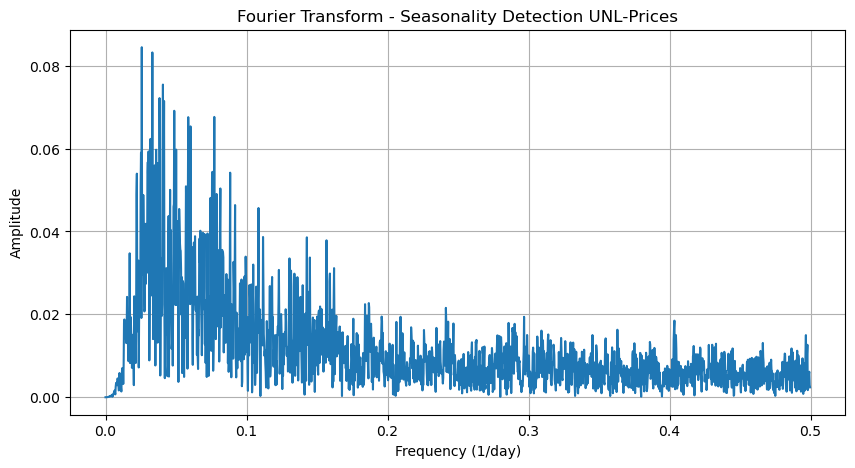

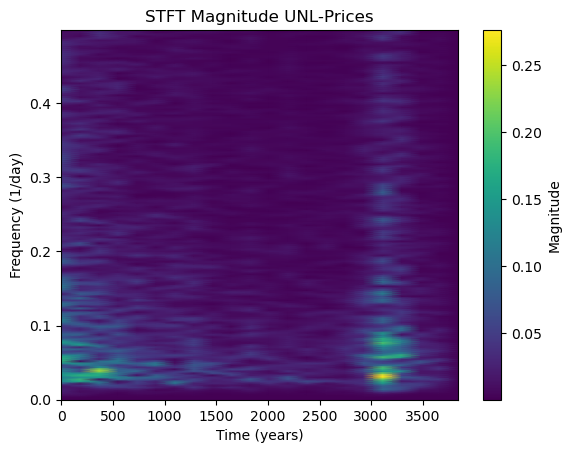

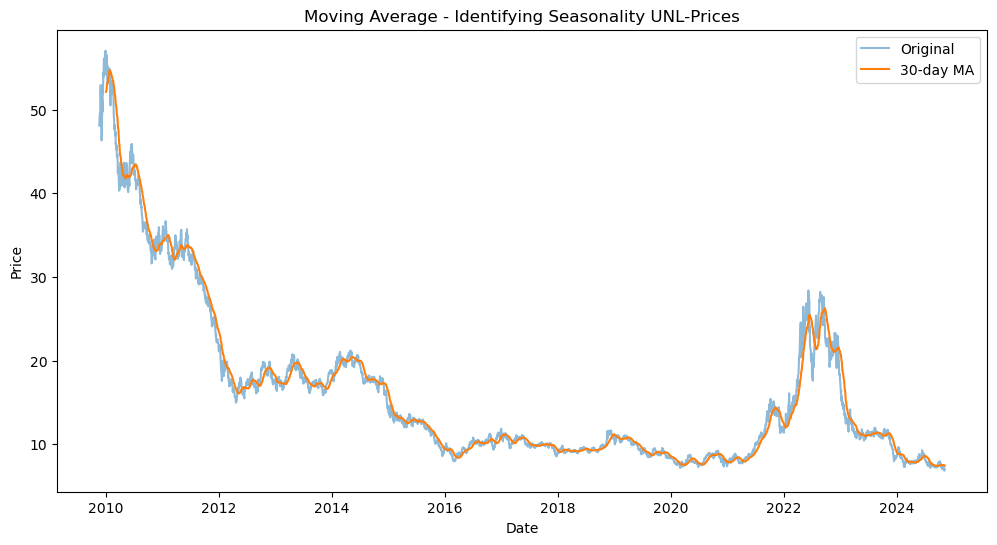

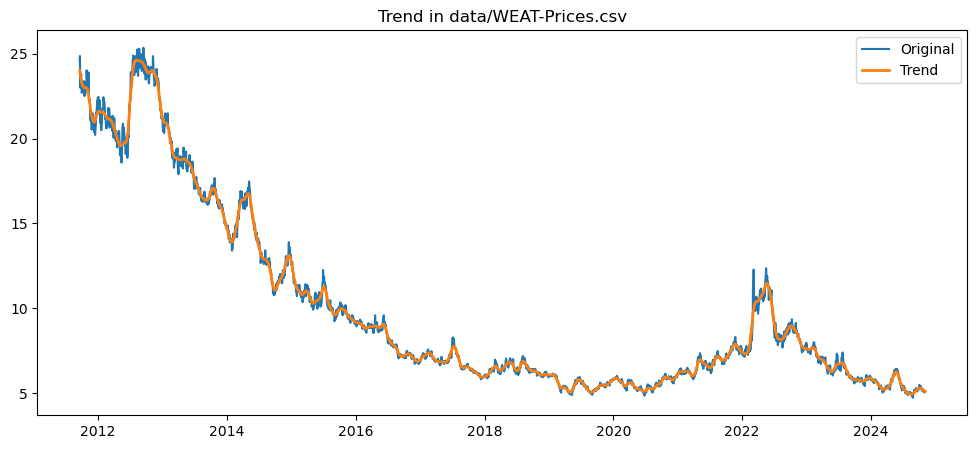

Strongest detected seasonal periods (in days) and their amplitudes:
Period: 35.07 days, Amplitude: 0.04170
Period: 27.02 days, Amplitude: 0.04007
Period: 32.32 days, Amplitude: 0.03887
Period: 18.73 days, Amplitude: 0.03639
Period: 29.44 days, Amplitude: 0.03606


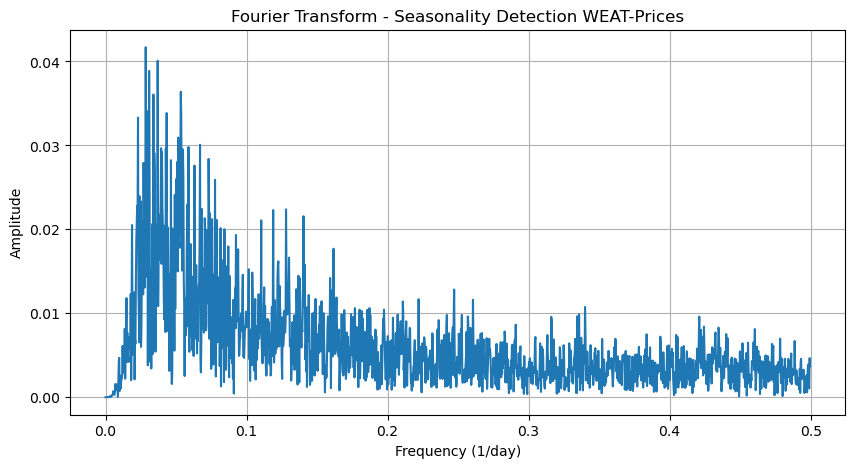

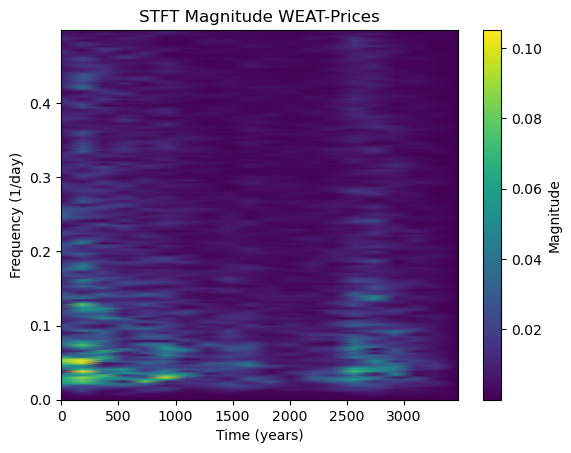

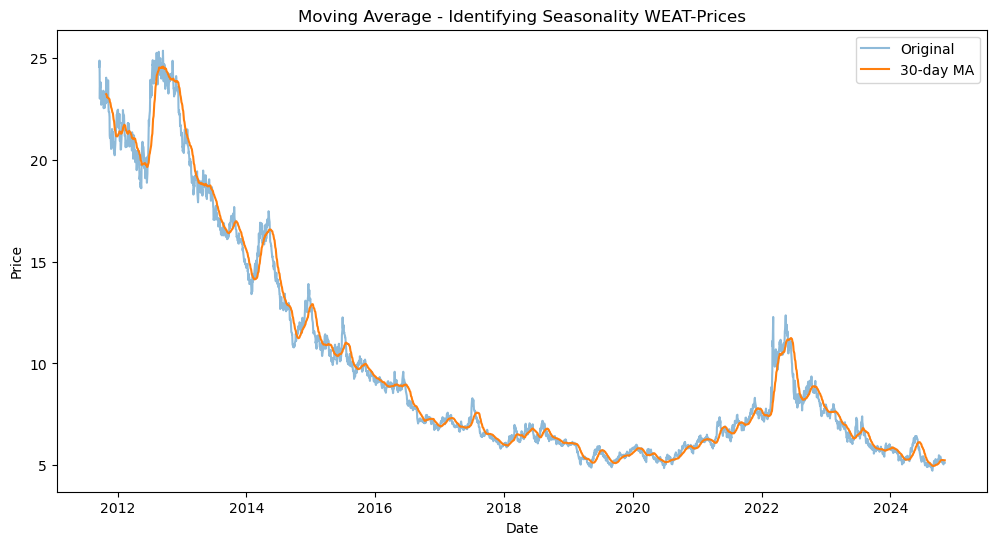

In [2]:
from scipy.signal import find_peaks
# lambda refers to the smoothing parameter and 14400 is about daily data
def advanced_detrend(df, column="Close", lamb=14400):
    cycle, trend = hpfilter(df[column], lamb=lamb)
    df["Trend"] = trend
    df[column] = cycle
    return df, trend

def preprocess_data(df, column="Open"):
    df = df.copy()
    df[column] = detrend(df[column])
    return df

def fourier_analysis(df, dataset, column="Close"):
    N = len(df)
    T = 1
    y = df[column].values
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    amplitudes = 2.0 / N * np.abs(yf[:N//2])
    peaks, _ = find_peaks(amplitudes, height=0.05 * max(amplitudes))
    sorted_indices = np.argsort(amplitudes[peaks])[::-1]  # Sort from highest to lowest
    strongest_peaks = peaks[sorted_indices][:5]  # Select the top 5

    dominant_periods = 1 / xf[strongest_peaks]
    dominant_amplitudes = amplitudes[strongest_peaks]
    print("Strongest detected seasonal periods (in days) and their amplitudes:")
    for period, amplitude in zip(dominant_periods, dominant_amplitudes):
        print(f"Period: {period:.2f} days, Amplitude: {amplitude:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier Transform - Seasonality Detection {dataset}")
    plt.grid()
    plt.show()

def stft_analysis(df, commodity_name, column="Close"):
    f, t, Zxx = stft(df[column], nperseg=365)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title(f'STFT Magnitude {commodity_name}')
    plt.ylabel('Frequency (1/day)')
    plt.xlabel('Time (years)')
    plt.colorbar(label='Magnitude')
    plt.show()

# Moving Average & Seasonal Overlay
def moving_average(df, dataset, column="Close", window=30):
    df[f"{column}_MA"] = df[column].rolling(window=window).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label='Original', alpha=0.5)
    plt.plot(df.index, df[f"{column}_MA"], label=f'{window}-day MA')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Moving Average - Identifying Seasonality {dataset}")
    plt.legend()
    plt.show()

datasets = ["data/BG-Prices.csv", "data/CORN-Prices.csv", "data/DBA-Prices.csv", "data/GLD-Prices.csv", "data/SLV-Prices.csv","data/UNL-Prices.csv","data/WEAT-Prices.csv"]
for dataset in datasets:
    start, end = "/", "-"
    commodity_name = dataset.split("/")[-1].split(".")[0]
    df = pd.read_csv(dataset, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)

    df_processed, trend = advanced_detrend(df.copy())  # HP Filter

    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df["Close"], label="Original")
    plt.plot(df.index, trend, label="Trend", linewidth=2)
    plt.title(f"Trend in {dataset}")
    plt.legend()
    plt.show()

    fourier_analysis(df_processed, commodity_name)
    stft_analysis(df_processed, commodity_name)
    moving_average(df, commodity_name, "Close")

